# 20.5 8 Machine Learning (DL) Prototype

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import seaborn as sns

### load processed bizbuysell dataset

In [88]:
df_in=pd.read_parquet('data/bizwiz_value_score_2.parquet')

In [89]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12143 entries, 1427 to 36567
Data columns (total 32 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   id                                                    12143 non-null  float64
 1   pptitle                                               12143 non-null  object 
 2   ppdesc                                                12143 non-null  object 
 3   ppdetails                                             12143 non-null  object 
 4   ppfinancials                                          12143 non-null  object 
 5   pcategories                                           12143 non-null  object 
 6   COUNTY_NAME                                           12143 non-null  object 
 7   STATE_NAME                                            12143 non-null  object 
 8   price                                                 1214

### vectorize text

In [90]:
vect_text=TfidfVectorizer(stop_words='english',ngram_range=(1, 2),max_df=0.5,min_df=20)

In [91]:
text= df_in.pptitle + ' ' + df_in.ppdesc + ' ' + df_in.ppdetails + ' ' + df_in.ppfinancials 

In [92]:
%time X_text = vect_text.fit_transform(text)

CPU times: user 4.92 s, sys: 24.8 ms, total: 4.94 s
Wall time: 4.94 s


In [93]:
X_text.shape

(12143, 13646)

### model A

In [94]:
XA_train, XA_test, yA_train, yA_test = train_test_split(X_text, df_in.price,random_state=1)

In [98]:
sgd_regr_A = SGDRegressor()

In [99]:
%time sgd_regr_A.fit(XA_train, yA_train)

CPU times: user 6.99 s, sys: 0 ns, total: 6.99 s
Wall time: 5.78 s


SGDRegressor()

In [100]:
yA_pred = sgd_regr_A.predict(XA_test)

In [101]:
r2A=r2_score(yA_test,yA_pred)

In [102]:
r2A

0.3241977481420646

In [103]:
dfr=pd.DataFrame()
dfr['test']=yA_test
dfr['pred']=yA_pred
sns.regplot(data=dfr, y='pred', x='test')

<Axes: xlabel='test', ylabel='pred'>

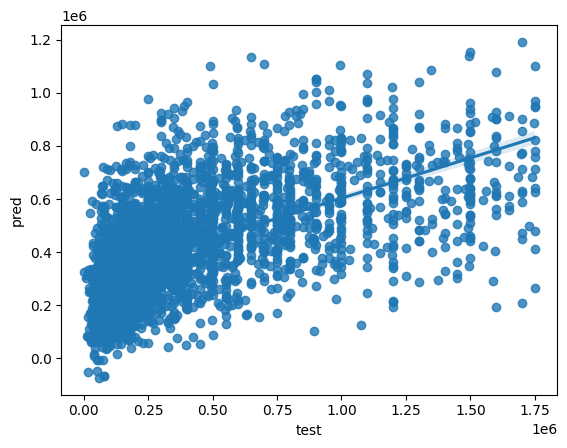

### compress vector text

In [200]:
#TODO 1K
pca_text=PCA(100)

In [201]:
%time X_text_pca = pca_text.fit_transform(X_text.toarray())

CPU times: user 2min 19s, sys: 29.5 s, total: 2min 49s
Wall time: 18 s


In [202]:
X_text_pca.shape

(12143, 200)

### model B

In [184]:
XB_train, XB_test, yB_train, yB_test = train_test_split(X_text_pca, df_in.price,random_state=1)

In [185]:
sgd_regr_B = SGDRegressor()

In [186]:
%time sgd_regr_B.fit(XB_train, yB_train)

CPU times: user 1.87 s, sys: 0 ns, total: 1.87 s
Wall time: 1.85 s


SGDRegressor()

In [187]:
yB_pred = sgd_regr_B.predict(XB_test)

In [188]:
r2B=r2_score(yB_test,yB_pred)

In [189]:
r2B

0.24550598598985474

<Axes: xlabel='test', ylabel='pred'>

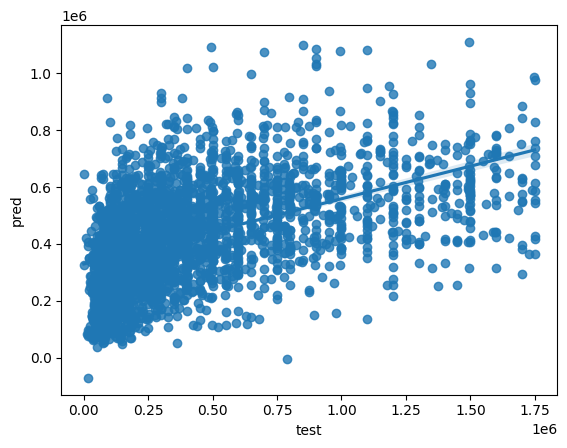

In [190]:
dfr=pd.DataFrame()
dfr['test']=yB_test
dfr['pred']=yB_pred
sns.regplot(data=dfr, y='pred', x='test')

### model C

In [151]:
features=[
    'cash_flow', 
    'gross_revenue',
    'established', 
    'POVERTY_PERCENT', 
    'MEDIAN_HOUSEHOLD_INCOME',
    'Abs(established - sqrt(gross_revenue))',
    'Abs(sqrt(MEDIAN_HOUSEHOLD_INCOME) - sqrt(cash_flow))',
    'Abs(sqrt(cash_flow) - established)',
    'log(MEDIAN_HOUSEHOLD_INCOME + cash_flow)',
    'sqrt(established + sqrt(gross_revenue))',
    'Abs(POVERTY_PERCENT**2 - sqrt(cash_flow))',
    '1/(sqrt(MEDIAN_HOUSEHOLD_INCOME) + cash_flow)',
    'POVERTY_PERCENT**2*cash_flow',
    '1/(-sqrt(gross_revenue) + 1/POVERTY_PERCENT)',
    'sqrt(gross_revenue/POVERTY_PERCENT)',
    'POVERTY_PERCENT**3*sqrt(gross_revenue)',
    'sqrt(MEDIAN_HOUSEHOLD_INCOME)*established**3',
    '(sqrt(MEDIAN_HOUSEHOLD_INCOME) + established)**3']

In [152]:
XC_train, XC_test, yC_train, yC_test = train_test_split(df_in[features], df_in.price,random_state=1)

In [153]:
rf_regr_C = RandomForestRegressor()

In [154]:
%time rf_regr_C.fit(XC_train, yC_train)

CPU times: user 10.3 s, sys: 0 ns, total: 10.3 s
Wall time: 10.3 s


RandomForestRegressor()

In [155]:
yC_pred = sgd_regr_C.predict(XC_test)

In [156]:
r2C=r2_score(yC_test,yC_pred)

In [157]:
r2C

0.5862250956207508

<Axes: xlabel='test', ylabel='pred'>

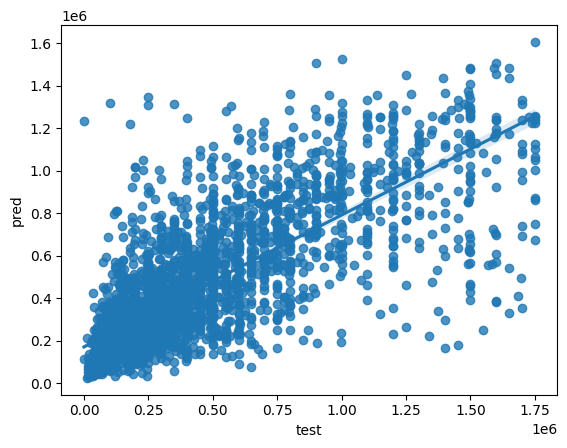

In [158]:
dfr=pd.DataFrame()
dfr['test']=yC_test
dfr['pred']=yC_pred
sns.regplot(data=dfr, y='pred', x='test')

### Model D

In [203]:
%time XD=np.hstack((X_text_pca,df_in[features].to_numpy()))

CPU times: user 7.36 ms, sys: 4.25 ms, total: 11.6 ms
Wall time: 7.76 ms


In [204]:
XD.shape

(12143, 218)

In [205]:
XD_train, XD_test, yD_train, yD_test = train_test_split(XD, df_in.price,random_state=1)

In [206]:
rf_regr_D = RandomForestRegressor()

In [207]:
%time rf_regr_D.fit(XD_train, yD_train)

CPU times: user 2min 29s, sys: 0 ns, total: 2min 29s
Wall time: 2min 28s


RandomForestRegressor()

In [208]:
yD_pred = rf_regr_D.predict(XD_test)

In [209]:
r2D=r2_score(yD_test,yD_pred)

In [210]:
r2D

0.6598888864044392

<Axes: xlabel='test', ylabel='pred'>

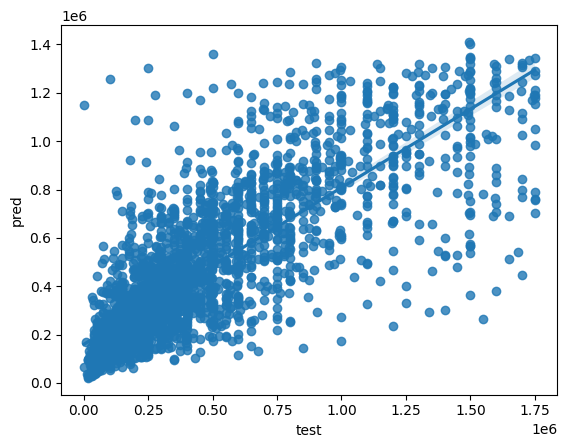

In [211]:
dfr=pd.DataFrame()
dfr['test']=yD_test
dfr['pred']=yD_pred
sns.regplot(data=dfr, y='pred', x='test')

### summary

[Text(0.5, 1.0, 'price model R2 scores')]

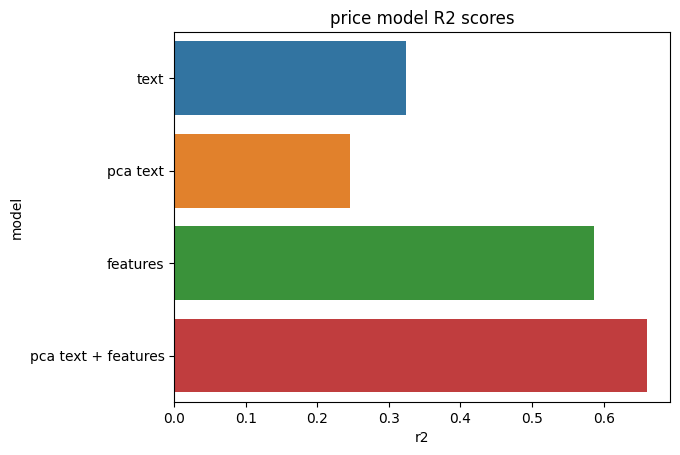

In [220]:
dfr=pd.DataFrame()
dfr['model']=['text','pca text','features','pca text + features']
dfr['r2']=[ r2A, r2B, r2C, r2D]
sns.barplot(data=dfr, x='r2', y='model',orient = 'h').set(title='price model R2 scores')

With further optimization of hyperparameters, model D type model should be able to get a good r2 score. 